# Experimental Classifier

Source:
+ CLEF 2016,2013 
+ GEL,PLATES IMAGES FROM PUBMED-



### 1. Importing Libraries

In [1]:
import os
import sys
module_path = "../src"
#os.environ["WANDB_SILENT"] = "true" # Environment Variable to make wandb silent
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# 1. General Libraries
import pandas as pd
import numpy as np
from pathlib import Path
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
# 2. DataModule & Class Libraries
from utils.label_encoder import label_encoder_target
from utils.calc_stat import calc_dataset_mean_std
from dataset.ImageDataModule import ImageDataModule
from dataset.ImageDataset import ImageDataset
from models.EfficientNetClass import EfficientNetClass
from models.ResNetClass import ResNetClass

# 3. Pytorch & Pytorch Lightning Libraries
from pytorch_lightning import Trainer,seed_everything
from torchvision import transforms
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger
import torch
# 4. Wandb Tracker Experiements
import wandb

In [3]:
BASE_PATH = Path('/mnt')
print(f"My base path is {BASE_PATH}")
DATA_PATH = '../data/experimental_dataset.csv'
print(f"The given dataset is located here: {DATA_PATH}")
OUTPUT_DIR = Path('/mnt/artifacts/experiments/')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH 

My base path is /mnt
The given dataset is located here: ../data/experimental_dataset.csv
Let's use this folder: /mnt/artifacts/experiments to save our artifacts.


In [4]:
SEED = 42 
seed_everything(42)
PROJECT = 'Biomedical-Image-Classification-Experimental'
NUM_WORKERS = 72 # workers on the cluster, normally 2 or 4 on a laptop
METRIC_MONITOR = "val_avg_loss"
OUTPUT_PROJECT = OUTPUT_DIR/PROJECT
print(f"Let's use this folder {OUTPUT_PROJECT} to save our sweep iterations")
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

Let's use this folder /mnt/artifacts/experiments/Biomedical-Image-Classification-Experimental to save our sweep iterations


In [5]:
os.makedirs(OUTPUT_PROJECT, exist_ok=True) # Check if it is false

### 3. Reading the Data & Label Encoding Classes
In this step, we read the csv file and apply a label encoder to the classes in order to run the classifier only with the class "Experimental"

In [6]:
df = pd.read_csv(DATA_PATH, sep='\t')
le_encoder_experimental,dict_label = label_encoder_target(df,target_col='modality')
df.head()

,img,modality,source,img_path,higher_modality,split_set
0,1423-0127-16-6-3-1.jpg,GEL,clef16,subfigure-classification/2016/train/GGEL/1423-...,EXPERIMENTAL,VAL
1,1423-0127-16-6-5-2.jpg,GEL,clef16,subfigure-classification/2016/train/GGEL/1423-...,EXPERIMENTAL,TRAIN
2,1423-0127-16-6-5-3.jpg,GEL,clef16,subfigure-classification/2016/train/GGEL/1423-...,EXPERIMENTAL,TRAIN
3,1423-0127-17-22-2-1.jpg,GEL,clef16,subfigure-classification/2016/train/GGEL/1423-...,EXPERIMENTAL,VAL
4,1423-0127-17-22-2-2.jpg,GEL,clef16,subfigure-classification/2016/train/GGEL/1423-...,EXPERIMENTAL,TRAIN


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


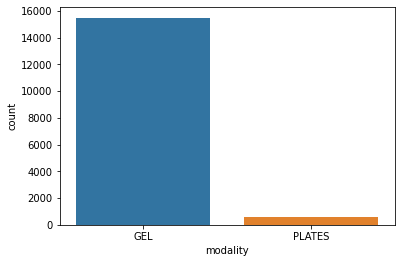

In [7]:
sns.countplot(df['modality'])
plt.show()

In [8]:
transform_list = [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
]
transform  = transforms.Compose(transform_list)
train_dataset   = ImageDataset   (DATA_PATH,
                                  le_encoder_experimental,
                                  str(BASE_IMG_DIR),
                                  'TRAIN',
                                  image_transform=transform,
                                  label_name='modality',
                                  target_class_col='split_set',
                                  path_col='img_path')

mean, std =calc_dataset_mean_std(train_dataset, batch_size=32, num_workers=72)
print(f"Mean:  {mean}")
print(f"Std :  {std}")


Mean:  tensor([0.8631, 0.8631, 0.8634])
Std :  tensor([0.2319, 0.2320, 0.2318])


### 4. Sweep Running
+ First We will define the image transformations that we are goint to use for the training , evaluation and test

In [9]:
# Image Transformations
# 1.1 Train Transformations
train_transform = [
                    transforms.ToPILImage(),
                    transforms.Resize((256, 256)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomRotation(15),
                    transforms.CenterCrop((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean.numpy(), std.numpy())
                ]
train_transform  = transforms.Compose(train_transform )

# 1.2 Valid Transformations
val_transform = [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean,std)
                ]
val_transform = transforms.Compose(val_transform)

# 1.3 Test Transformations
test_transform = [
                  transforms.ToPILImage(),
                  transforms.Resize((224, 224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean.numpy(),std.numpy())
                  ]
test_transform = transforms.Compose(test_transform)

In [10]:
print(f"PROJECT NAME: {PROJECT}")
print(f"Metric Monitor: {METRIC_MONITOR}")

PROJECT NAME: Biomedical-Image-Classification-Experimental
Metric Monitor: val_avg_loss


### 4.1 ResnetClassifier

In [19]:
sweep_config = {
  "method": "grid",   # Random search
  "metric": {           # We want to maximize val_acc
      "name": METRIC_MONITOR, # Used accuracy
      "goal": "minimize"
  },
  "parameters": {
        "lr": {
            # log uniform distribution between exp(min) and exp(max)
            "distribution": "categorical",
            "values" : [1e-6,1e-5,1e-4]
        },
        "fine_tuned_from":{
            "distribution": "categorical",
            "values" : ["whole"]
        },
        "name":{
            "distribution": "categorical",
            "values" : ["resnet18","resnet34","resnet50","resnet101","resnet152"]
        },
        "batch_size":{
            "distribution": "categorical",
            "values" : [16,32]
            
        }
      
    }
}

In [20]:
sweep_id = wandb.sweep(sweep_config, project=PROJECT)

Create sweep with ID: 6rcr5igw
Sweep URL: https://wandb.ai/williamberrios/Biomedical-Image-Classification-Experimental/sweeps/6rcr5igw


In [21]:
OUTPUT_SWEEP = OUTPUT_PROJECT / sweep_id
os.makedirs(OUTPUT_SWEEP, exist_ok=False) # Check if it is false
with open(OUTPUT_SWEEP / 'sweep_config.yml', 'w') as outfile:
    yaml.dump(sweep_config, outfile, default_flow_style=False)

In [22]:
def sweep_iteration():
    # set up W&B logger
    wandb.init()    # required to have access to `wandb.config`
    wandb_logger =  WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'],reinit = True)
    wandb_logger.experiment.save()
    print(f"Name of the Experiment: {wandb_logger.experiment.name}")
    output_run_path = OUTPUT_SWEEP / wandb_logger.experiment.name 
    os.makedirs(output_run_path, exist_ok=False) # Check if it is false

    # setup data
    dm = ImageDataModule( batch_size       = wandb.config.batch_size,
                          label_encoder    = le_encoder_experimental,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
    dm.prepare_data()
    dm.setup()
    dm.set_seed()
    # Callbacks
    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    early_stop_callback = EarlyStopping(
        monitor=METRIC_MONITOR,
        min_delta=0.0,
        patience=5,
        verbose=True,
        mode='min'
    )
    # setup model - note how we refer to sweep parameters with wandb.config
    num_classes = len(df.modality.unique())
    print(f"Num_Classes {num_classes}")
    model = ResNetClass(      name            = wandb.config.name,
                              num_classes     = num_classes,
                              pretrained      = True,
                              fine_tuned_from = wandb.config.fine_tuned_from,
                              lr              = wandb.config.lr,
                              metric_monitor  = METRIC_MONITOR,
                              mode_scheduler  = "min",
                              class_weights   = dm.class_weights,
                              mean_dataset    = mean.numpy(),
                              std_dataset     = std.numpy())
    
    # setup Trainer
    trainer = Trainer(gpus=1,
                  max_epochs=100,                  
                  callbacks=[early_stop_callback,lr_monitor],
                  deterministic= True,
                  logger=wandb_logger,
                  num_sanity_val_steps=0)

    # train
    trainer.fit(model, dm)
    # Save the model
    trainer.save_checkpoint(str(output_run_path / 'final.pt'))
    # Get testS metric
    trainer.test(model, test_dataloaders=dm.val_dataloader())
    del model,trainer,dm
    torch.cuda.empty_cache() 
    wandb.finish()

In [ ]:
wandb.agent(sweep_id, function=sweep_iteration);

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ad36oj70 with config:
wandb: 	batch_size: 16
wandb: 	fine_tuned_from: whole
wandb: 	lr: 1e-06
wandb: 	name: resnet18
wandb: wandb version 0.10.19 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


Name of the Experiment: giddy-sweep-1
Num_Classes 2


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'name' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'fine_tuned_from' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lr' was locked by 'sweep' (ignored update).

  | Name      | Type             | Params
-----------------------------------------------
0 | criterion | CrossEntropyLoss | 0     
1 | model     | ResNet           | 11.2 M
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


## 5. Testing

In [23]:
cp /mnt/artifacts/experiments/Biomedical-Image-Classification-Experimental/6rcr5igw/helpful-sweep-16/final.pt /mnt/artifacts/models/Experimental

In [25]:
model_path =  '/mnt/artifacts/experiments/Biomedical-Image-Classification-Experimental/6rcr5igw/helpful-sweep-16/final.pt'
# setup data
dm = ImageDataModule(     batch_size       = 32,
                          label_encoder    = le_encoder_experimental,
                          data_path        = str(DATA_PATH), 
                          base_img_dir     = str(BASE_IMG_DIR),
                          seed             = SEED,   
                          image_transforms = [train_transform,val_transform,test_transform],
                          num_workers      = 72,
                          target_class_col ='split_set',
                          modality_col     ='modality',
                          path_col         ='img_path')
dm.prepare_data()
dm.setup()
dm.set_seed()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Accuracy: 99.56689453125
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2009
         1.0       0.95      0.91      0.93        69

    accuracy                           1.00      2078
   macro avg       0.98      0.96      0.97      2078
weighted avg       1.00      1.00      1.00      2078


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Balanced Accuracy': 0.9557750990109724,
 'Macro F1-Score': 0.965547542070795,
 'test_acc': tensor(99.5669, device='cuda:0'),
 'test_loss': tensor(0.0284, device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_acc': 99.56689453125,
  'test_loss': 0.028388090431690216,
  'Macro F1-Score': 0.965547542070795,
  'Balanced Accuracy': 0.9557750990109724}]

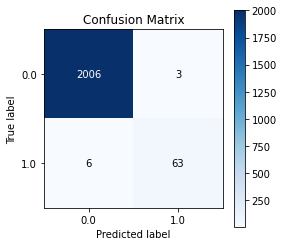

In [26]:
model = ResNetClass.load_from_checkpoint(model_path)
trainer = Trainer(gpus=1, logger=None)
trainer.test(model, test_dataloaders=dm.test_dataloader())